### REMINDER for the future
* Take into account the % fee for chargebacks, not just the order total

### Libraries

In [1]:
import sys
sys.path.insert(0,'/Users/jarad/Fake Folder/Python Libraries')

from jb_libraries import *
%matplotlib inline

from osh_data import *

### Script settings

In [2]:
r_write = 'yes'

In [3]:
date_end = '2019-01-31'

# this is for the predictive model
# the first month we started marking orders as "fraud - void" instead of deleting them
fraud_date_start = '2018-05-01' 

# this is for the giant data pull
# go back 1.5 years from date_end
d = str((pd.to_datetime(date_end) - pd.DateOffset(years = 1, months = 6)).date())[:7] + '-01'

# make the date_start the min date between fraud_date_start and the date 1.5 years ago
date_start = str(np.min([pd.to_datetime(fraud_date_start).date(), pd.to_datetime(d).date()]))

m = 3
three_months_ago = str((pd.to_datetime(date_end) - pd.DateOffset(months = (m-1))).date())[:7] + '-01'

csv_path = '/Users/jarad/Fake Folder/CSP/Recurring/Fraud and Chargeback Report/CSVs/'

### Chart settings

In [4]:
style_sheet_path = '/Users/jarad/Fake Folder/Matplotlib Stylesheets/the_pillars_stylesheet.mplstyle'
plt.style.use(style_sheet_path)

alpha = 0.8

adablue01 = '#00ffff'
adablue02 = '#00a6e9'
adapink = '#ff00ff'
adapurple = '#662d91'
adayellow = '#ffff00'
adagreen = '#00ff00'

colors = [adablue01,adablue02,adapink,adayellow,adapurple,adagreen] * 10

### Some info
From Kelly in email with subject line "CSP Monthly Chargeback/Fraud Report":
* Fraud stopped
* Fraud - Void (orders_status = 15)


* Fraud not stopped
* Fraud - Confirmed (orders_status = 9)

*****

* [CSP Shift Report Google Doc](https://docs.google.com/spreadsheets/d/1RfqZtU-qZY7_Xn1gAZ15LBS2nshO5RBwPLRDmfFTx4M/edit#gid=300944739), for reference, but numbers are different from db since the google doc is user-entered; we don't use it here in this script, we get the data straight from the db.

### Get data

In [5]:
osh_main = get_osh_data(fraud_date_start, date_end)


== osh_main start ==


== osh_main end ==



### All statuses

In [6]:
a = osh_main.groupby(['year and month added','orders status name'])[['order subtotal']].sum().unstack(1).fillna(0)
a.columns = a.columns.droplevel(0)

fmt = ['m0'] * len(a.columns)
a.format_(fmt)

,Billed,Fraud - Confirmed,Fraud - Pending,Fraud - Void,No Shipment Necessary,Pending,Printed,Processing,Return,Shipped,Voided
year and month added,,,,,,,,,,,
2018-05,$0,"$5,938",$0,"$14,005","$31,828",$0,$0,$270,"$22,896","$3,843,556","$118,662"
2018-06,$0,"$1,508",$0,"$16,146","$7,724","$16,511",$0,$50,"$17,751","$3,428,852","$54,592"
2018-07,$0,"$3,664",$0,"$8,747","$1,570","$400,000",$0,$170,"$33,599","$3,368,009","$62,569"
2018-08,$366,"$1,024",$0,"$15,524","$3,465",$0,$0,$350,"$33,196","$3,537,080","$57,495"
2018-09,"$1,423",$542,$0,"$16,993","$153,684","$30,965",$0,$166,"$17,987","$3,052,417","$66,984"
2018-10,$0,"$1,535",$0,"$20,463","$4,075","$84,635",$0,$200,"$30,163","$3,666,439","$106,605"
2018-11,$0,"$1,720",$0,"$8,969","$10,597","$18,256",$0,$120,"$13,834","$3,558,402","$192,064"
2018-12,$0,"$1,240",$0,"$3,482","$31,438","$289,750",$30,"$1,815","$18,792","$4,124,245","$61,531"
2019-01,$0,"$1,578","$1,312","$7,274","$54,168","$808,049","$138,145","$47,288","$16,973","$3,981,103","$50,431"


### Just fraud

In [7]:
ls = ['fraud - confirmed','fraud - void']

fraud_main = osh_main[(osh_main['orders status name'].isin(ls))
                    & (osh_main['date added'] >= fraud_date_start)].copy()
fraud_main.reset_index(drop = True, inplace = True)

### Get total revenue data

In [8]:
# recall that daily_stats uses the order subtotal
ds_main = pd.read_sql(
'''
SELECT
timestamp AS date,
d_value AS total_revenue
FROM daily_stats
WHERE d_class = 'd_all'
AND timestamp BETWEEN ' '''+ date_start +''' ' AND ' '''+ date_end +''' '
''', db)

col_fix(ds_main)

ds_main['date'] = pd.to_datetime(ds_main['date'])
ds_main['year and month'] = jb_dates(ds_main['date'], 'year and month')

ds = ds_main.groupby('year and month')[['total revenue']].sum()

### Structure it

In [9]:
fraud = fraud_main.groupby(['year and month added','orders status name'])[['order subtotal']].sum().unstack(1).fillna(0)
fraud.columns = fraud.columns.droplevel(0)

fraud['total fraud'] = fraud.sum(1)
fraud['total revenue'] = fraud.index.to_series().map(dict(zip(ds.index.to_series(), ds['total revenue'])))
fraud['% of fraud stopped'] = fraud['fraud - void']/fraud['total fraud']
fraud['fraud as a % of total revenue'] = fraud['total fraud']/fraud['total revenue']

In [10]:
fmt = ['m0','m0','m0','m0','p2','p2']

display(jb_mean(fraud, fmt))
fraud.format_(fmt)

,mean
Fraud - Confirmed,"$2,083"
Fraud - Void,"$12,400"
Total Fraud,"$14,484"
Total Revenue,"$3,505,479"
% Of Fraud Stopped,83.97%
Fraud As A % Of Total Revenue,0.41%


,Fraud - Confirmed,Fraud - Void,Total Fraud,Total Revenue,% Of Fraud Stopped,Fraud As A % Of Total Revenue
year and month added,,,,,,
2018-05,"$5,938","$14,005","$19,943","$3,933,957",70.23%,0.51%
2018-06,"$1,508","$16,146","$17,654","$3,272,851",91.46%,0.54%
2018-07,"$3,664","$8,747","$12,411","$3,448,737",70.48%,0.36%
2018-08,"$1,024","$15,524","$16,548","$3,141,298",93.81%,0.53%
2018-09,$542,"$16,993","$17,534","$3,081,421",96.91%,0.57%
2018-10,"$1,535","$20,463","$21,998","$4,164,699",93.02%,0.53%
2018-11,"$1,720","$8,969","$10,689","$3,886,270",83.91%,0.28%
2018-12,"$1,240","$3,482","$4,722","$3,153,960",73.73%,0.15%
2019-01,"$1,578","$7,274","$8,852","$3,466,120",82.18%,0.26%


### Plot it

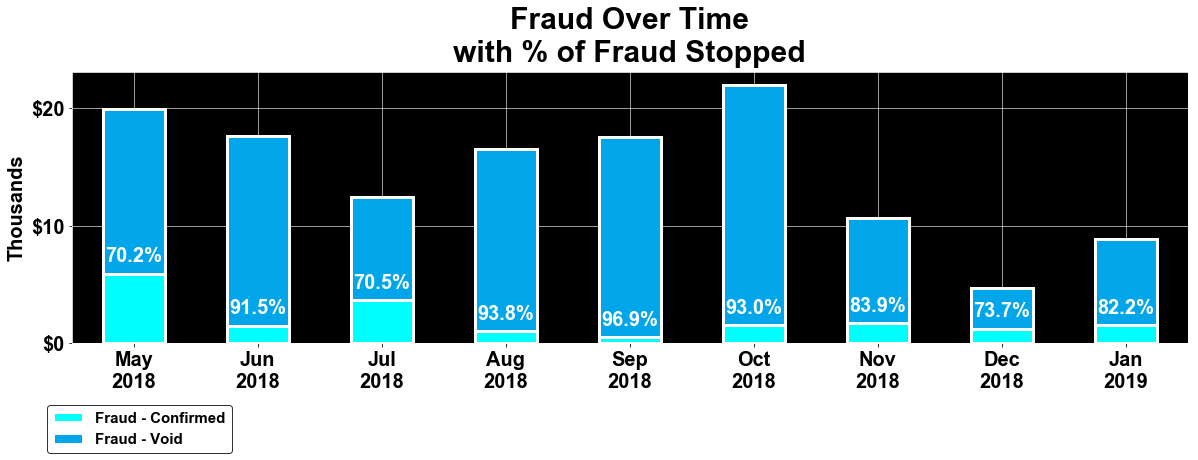

In [11]:
fig, ax = plt.subplots(figsize = (20,5))

cols = ['fraud - confirmed','fraud - void']

fraud[cols].plot(ax = ax,
                 kind = 'bar',
                 stacked = True,
                 edgecolor = 'white',
                 lw = 3,
                 color = colors,
                 zorder = 5)

ax.set_xticklabels(jb_dates(pd.Series(fraud.index), 'year and month xticks'), rotation = 0, fontsize = 20)
ax.set_yticklabels(['${:,.0f}'.format(x/1000) for x in ax.get_yticks()], fontsize = 20)
ax.set_ylabel('Thousands', fontsize = 20)
ax.set_xlabel('')
ax.legend([x.title() for x in cols], bbox_to_anchor = (0.15,-0.20), edgecolor = 'black', fontsize = 15)
ax.set_title('Fraud Over Time\nwith % of Fraud Stopped', y = 1.02, fontsize = 30)
ax.grid(color = 'white', alpha = 0.75, zorder = 0)

for i in range(len(fraud)):
    x = i
    y = fraud.iloc[i]['fraud - confirmed'] + 1000
    wrt = fraud.iloc[i]['% of fraud stopped']
    wrt2 = '{:,.1f}%'.format(wrt * 100)
    ax.annotate(wrt2, xy = (x,y), ha = 'center', fontsize = 20, color = 'white', zorder = 10)
    
plt.show()

### 95% confidence intervals per month

In [12]:
fmt = ['m0','m0','m0','m0','p2','p2']
jb_conf(fraud).loc['lower':'upper'].format_(fmt)

,Fraud - Confirmed,Fraud - Void,Total Fraud,Total Revenue,% Of Fraud Stopped,Fraud As A % Of Total Revenue
lower,$791,"$8,161","$10,139","$3,200,657",75.90%,0.29%
mean,"$2,083","$12,400","$14,484","$3,505,479",83.97%,0.41%
upper,"$3,375","$16,640","$18,828","$3,810,301",92.04%,0.53%


# Chargebacks

In [13]:
cb_main = osh_main[osh_main['admin comments'].str.contains('chargeback', case = False)].copy()

by_month = cb_main.groupby(['year and month added','payment method'])[['order subtotal']].sum().unstack(1).fillna(0)
by_month.columns = by_month.columns.droplevel(0)

fmt = ['m0'] * len(by_month.columns)
display(by_month.format_(fmt))

print('confidence intervals for avg per month')
jb_conf(by_month).loc[:'upper'].format_(fmt).T

,Amazon Payments,Credit Card,Paypal
year and month added,,,
2018-05,$0,"$2,149",$0
2018-06,$0,$807,$0
2018-07,$45,"$1,611",$0
2018-08,$0,$709,$33
2018-09,$0,$147,$0
2018-10,$33,"$1,177",$35
2018-12,$0,$956,$0
2019-01,$0,$260,$0


confidence intervals for avg per month


,lower,mean,upper
Amazon Payments,$-6,$10,$25
Credit Card,$419,$977,"$1,535"
Paypal,$-5,$8,$22


*****
# Prepare data for predictive model
*****
From "Dev request draft regarding chargeback/fraud tools"

* Date Chargeback received (date the billing status was updated to chargeback)
* Date order placed
* OID
* Total $ amount 
* Email domain
* Billing state
* Delivery state
* IP location
* Part Numbers in order
* Flagged y/n
* Prev Customer y/n
* If the address includes 'hotel', 'motel', 'inn'
* If the address includes number over 2000+ alpha 
* USA bin on non USA delivery/US delivery on non US bin
* Bin country does not match ip country
* Any of these product holds/alerts - https://volcano.adafruit.com/volcano/Order_Product_Hold_and_Alerts.php
* If the delivery phone number matches the delivery country
* If the email address itself appears sketchy (lots of characters strung together, doesn't match the customer name)
* If the name on the credit card for the order matches the shipping/billing names on the order
* If the order contains a high quantity of an easily resellable product (i.e. 10x PN 527)

### Get data

In [14]:
orders_super_main = pd.read_sql(
'''
SELECT
DATE(date_purchased) AS date_purchased,
orders_id,

customers_id,
customers_email_address,

billing_street_address,
billing_state,
billing_country,
billing_postcode,

delivery_street_address,
delivery_state,
delivery_country,
delivery_postcode,
delivery_phone,

ip_address,
ip_mismatch,

payment_module_code,

os.orders_status_name

FROM orders o

JOIN orders_status os ON o.orders_status = os.orders_status_id
''', db)

col_fix(orders_super_main)

In [15]:
ot = pd.read_sql(
'''
SELECT
orders_id,
value AS order_subtotal
FROM orders_total
WHERE class = 'ot_subtotal'

''', db)

col_fix(ot)

In [16]:
orders_super_main['order subtotal'] = orders_super_main['orders id'].map(dict(zip(ot['orders id'], ot['order subtotal'])))

### Add dates

In [17]:
orders_super_main['date purchased'] = pd.to_datetime(orders_super_main['date purchased'])
orders_super_main['year and month purchased'] = jb_dates(orders_super_main['date purchased'], 'year and month')

d1 = orders_super_main['year and month purchased'].min()
d2 = orders_super_main['year and month purchased'].max()

print('orders data is from {} to {}'.format(d1,d2))
print('{:,.0f} total lines of data'.format(len(orders_super_main)))

orders data is from 2005-10 to 2019-02
1,959,525 total lines of data


### Lower case

In [18]:
ls = []
for col in orders_super_main.columns:
    if orders_super_main[col].dtype == 'O':
        ls.append(col)
ls.remove('year and month purchased')

for col in ls:
    orders_super_main[col] = orders_super_main[col].str.lower()

### Map some fraud data

In [19]:
# order is fraud?
ls = ['fraud - confirmed','fraud - void']
orders_super_main['fraud'] = np.where(orders_super_main['orders status name'].isin(ls),
                                     'yes','no')

In [20]:
# customers id or customers email involved in fraud before?
df = orders_super_main[orders_super_main['fraud'] == 'yes']

ls1 = list(set(df['customers email address']))
ls2 = list(set(df['customers id'][df['customers id'] > 0]))

orders_super_main['fraud before'] = np.where((orders_super_main['customers email address'].isin(ls1))
                                           | (orders_super_main['customers id'].isin(ls2)),
                                            'yes','no')

### Flag Hotel, motel, inn

In [21]:
pre = '(?<=[^a-z])' # matches word if not preceded by letters
suf = '(?![a-z])' # matches word if not followed by letters

ls = ['inn','hotel','motel']
ls = [pre + x + suf for x in ls]

hotels = orders_super_main[(orders_super_main['billing street address'].str.contains('|'.join(ls), regex = True))
                         | (orders_super_main['delivery street address'].str.contains('|'.join(ls), regex = True))].copy()

orders_super_main['hotel'] = np.where(orders_super_main['orders id'].isin(hotels['orders id'].tolist()),'yes','no')

print('billing or delivery address contains "hotel","motel", or "inn"?')
orders_super_main['hotel'].value_counts()

billing or delivery address contains "hotel","motel", or "inn"?


no     1959136
yes        389
Name: hotel, dtype: int64

### Bin the order total data

In [22]:
a = orders_super_main[orders_super_main['fraud'] == 'yes']

conf = jb_conf(a[['order subtotal']]).loc[:'upper']

lower, mean, upper = [x[0] for x in conf.values]
print('the avg order subtotal for a fraud order is between ${:,.0f} and ${:,.0f} with an avg of ${:,.0f}'.format(lower,upper,mean))

the avg order subtotal for a fraud order is between $210 and $300 with an avg of $255


In [23]:
percentiles = np.arange(0,1.05,0.05)

bins = []
for p in percentiles:
    b = orders_super_main['order subtotal'].quantile(p)
    bins.append(b)
    
bins = sorted(list(set(bins)))

orders_super_main['order subtotal bins'] = pd.cut(orders_super_main['order subtotal'], bins)

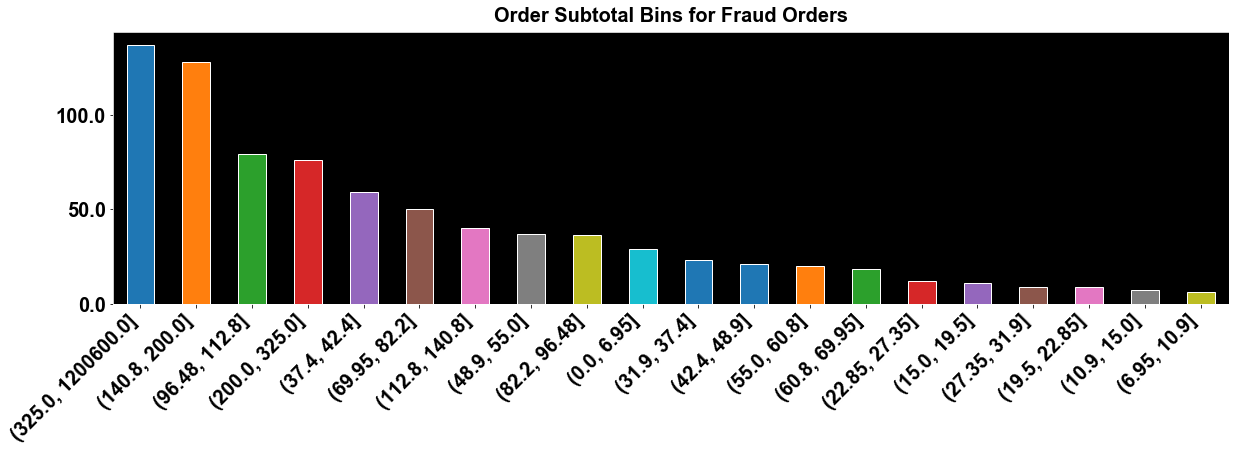

In [24]:
vc = orders_super_main[orders_super_main['fraud'] == 'yes']['order subtotal bins'].value_counts()

ax = vc.plot(kind = 'bar', edgecolor = 'white', figsize = (20,5))
ax.set_xticklabels(vc.index, fontsize = 20, rotation = 45, ha = 'right')
ax.set_yticklabels(ax.get_yticks(), fontsize = 20)
ax.set_title('Order Subtotal Bins for Fraud Orders', fontsize = 20, y = 1.02)
plt.show()

### Clean up postcodes
Take the first set of numbers before any dashes

In [25]:
for col in ['delivery','billing']:
    d = (orders_super_main[col + ' postcode'].str.split('-').str[0]).to_dict()
    orders_super_main[col + ' postcode'] = orders_super_main.index.map(d)

### Flag matching postcodes

In [26]:
orders_super_main['matching postcodes'] = np.where(orders_super_main['billing postcode'] == orders_super_main['delivery postcode'], 'yes', 'no')

In [27]:
v1 = orders_super_main['matching postcodes'].value_counts()
v2 = orders_super_main['matching postcodes'].value_counts().sum()
v3 = v1/v2
print('matching postcode proportions')
v3

matching postcode proportions


yes    0.856417
no     0.143583
Name: matching postcodes, dtype: float64

### Find US/non-US
If the billing country is US but the delivery country isn't, and vice versa

In [28]:
a = orders_super_main[(orders_super_main['billing country'] == 'united states')
                    | (orders_super_main['delivery country'] == 'united states')]
b = a[a['billing country'] != a['delivery country']]

orders_super_main['matching countries'] = np.where(orders_super_main['orders id'].isin(b['orders id'].tolist()),'yes','no')

### Find repeat customers

In [29]:
g1 = orders_super_main.groupby('customers email address')[['orders id']].count()
g1_email = g1[(g1['orders id'] > 1) & (g1.index != '')].index.tolist()

g2 = orders_super_main.groupby('customers id')[['orders id']].count()
g2_id = g2[(g2['orders id'] > 1) & (g2.index > 0)].index.tolist()

KeyboardInterrupt: 

In [ ]:
orders_super_main['repeat customer'] = np.where((orders_super_main['customers email address'].isin(g1_email))
                                              | (orders_super_main['customers id'].isin(g2_id)),
                                                'yes','no')

### Split off email domain

In [ ]:
orders_super_main['email domain'] = orders_super_main['customers email address'].str.split('@', expand = True)[1]

In [ ]:
vc = orders_super_main['email domain'].value_counts()
vc2 = pd.DataFrame(vc/vc.sum())
vc2.format_(['p2']).head(10)

In [ ]:
# top N most used email domains
n = 5
ls = vc.index[:n].tolist()

orders_super_main['email domain clean'] = np.where(orders_super_main['email domain'].isin(ls),
                                                   'common',
                                                   'not common')

### Map top parts by price

In [ ]:
parts = pd.read_sql(
'''
SELECT
part_id,
products_price
FROM parts
''', db)

col_fix(parts)

In [ ]:
q = 0.90
top_price = parts['products price'].quantile(q)

print('{:,.0f}% of prices are above or equal to ${:,.0f}'.format(q * 100, top_price))

ls = parts[parts['products price'] >= top_price]['part id'].tolist()

In [ ]:
op = pd.read_sql(
'''
SELECT
orders_id,
part_id
FROM orders_products
''', db)

col_fix(op)

In [ ]:
oids = list(set(op['orders id'][op['part id'].isin(ls)]))
orders_super_main['contains top part'] = np.where(orders_super_main['orders id'].isin(oids),'yes','no')

### Map whether the IP was flagged before

In [ ]:
ip_flags = pd.read_sql(
'''
SELECT
*
FROM fraud_log
''', db)

col_fix(ip_flags)

orders_super_main['ip flagged before'] = np.where(orders_super_main['ip address'].isin(ip_flags['ip'].tolist()), 'yes', 'no')

### Clean up IP mismatch

In [ ]:
d = {'1':'yes',
     '0':'no'}

orders_super_main['ip mismatch'] = [str(x) for x in orders_super_main['ip mismatch']]
for k,v in d.items():
    orders_super_main['ip mismatch'] = orders_super_main['ip mismatch'].str.replace(k,v)

### View nulls

In [ ]:
n = orders_super_main[orders_super_main.isnull().any(1)]

v1 = len(n)
v2 = len(orders_super_main)

print('nulls account for {:,.2f}% of total lines\ndrop them for excel'.format(v1/v2*100))

# For Excel

### Prepare data for writing

In [ ]:
min_oid = fraud_main['orders id'].min()
for_excel = orders_super_main[(orders_super_main['orders id'] >= min_oid)
                            & (orders_super_main['date purchased'].between(fraud_date_start, date_end))].copy()

d1 = str((for_excel['date purchased'].min()).date())
d2 = str((for_excel['date purchased'].max()).date())

print('excel data goes from {} to {}'.format(d1,d2))

In [ ]:
n = for_excel[for_excel.isnull().any(1)]

v1 = len(n)
v2 = len(for_excel)

print('nulls account for {:,.2f}% of total lines'.format(v1/v2*100))

if v1/v2 < 0.01:
    for_excel.dropna(inplace = True)
    for_excel.reset_index(drop = True, inplace = True)
    print('drop them for excel')
else:
    raise ValueError('check out ur nulls')
    
count = np.sum(n['fraud'] == 'yes')
print('\n{} nulls are fraud orders'.format(count))    

### Write to Excel for R script

In [ ]:
if r_write == 'yes':
    
    title = 'Fraud Detection Data for R'
    writer = pd.ExcelWriter(csv_path + title + '.xlsx', engine = 'xlsxwriter')
    
    for_excel.to_excel(writer, 'data', index = False)
    
    writer.save()

In [ ]:
for_excel['fraud'].value_counts()

# Rates of actual data

See [Confusion of the inverse](https://en.wikipedia.org/wiki/Confusion_of_the_inverse) for more.

* True Positive
* False Positive  


* True Negative
* False Negative

### Get data

In [ ]:
osh_super_main = pd.read_sql(
'''
SELECT
osh.orders_status_history_id,
osh.date_added AS date_and_time_added,
DATE(osh.date_added) AS date_added,
DATE(o.date_purchased) AS date_purchased,
osh.orders_id,
o.order_total,
LOWER(os.orders_status_name) AS orders_status_name,
LOWER(o.payment_method) AS payment_method,
admin_comments
FROM orders_status_history osh
JOIN orders_status os ON osh.orders_status_id = os.orders_status_id
JOIN orders o ON osh.orders_id = o.orders_id
WHERE DATE(o.date_purchased) BETWEEN ' '''+ fraud_date_start +''' ' AND ' '''+ date_end +''' '
''', db)

col_fix(osh_super_main)

### Restrict to OIDs that were sent to R

In [ ]:
oids = for_excel['orders id'].tolist()

osh_super_main.drop(osh_super_main[~osh_super_main['orders id'].isin(oids)].index, inplace = True)
osh_super_main.reset_index(drop = True, inplace = True)

### Check it

In [ ]:
v1 = len(for_excel)
v2 = len(set(osh_super_main['orders id']))

if v1 != v2:
    raise ValueError('totals do not match')

### Create rates

In [ ]:
for_rates = osh_super_main.drop_duplicates(['orders id','orders status name']).copy()

t = len(for_rates['orders id'].unique())
print('count of unique OIDs: {:,.0f}'.format(t))

### True Positive
We say fraud and it's fraud

In [ ]:
ls = for_rates[for_rates['orders status name'] == 'fraud - pending']['orders id'].tolist()

a = for_rates[(for_rates['orders id'].isin(ls))]

b = a.groupby(['orders id','orders status name'])[['orders id']].count().unstack(1)
b.columns = b.columns.droplevel(0)

tp = np.sum(b[['fraud - pending','fraud - void']].sum(1) > 1)

### False positive
We say fraud and it's not fraud

In [ ]:
ls = for_rates[for_rates['orders status name'] == 'fraud - pending']['orders id'].tolist()

a = for_rates[(for_rates['orders id'].isin(ls))]

b = a.groupby(['orders id','orders status name'])[['orders id']].count().unstack(1)
b.columns = b.columns.droplevel(0)

fp = np.sum(b[['fraud - pending','fraud - void']].sum(1) == 1)

### True Negative
We say not fraud and it's not fraud

In [ ]:
ls = for_rates[for_rates['orders status name'] == 'fraud - pending']['orders id'].tolist()

a = for_rates[~for_rates['orders id'].isin(ls)].groupby(['orders id','orders status name'])[['orders id']].count().unstack(1)
a.columns = a.columns.droplevel(0)

tn = np.sum(a[['fraud - confirmed','fraud - void']].sum(1) == 0)

### False negative
We say not fraud and it's fraud

In [ ]:
ls = for_rates[for_rates['orders status name'] == 'fraud - pending']['orders id'].tolist()

a = for_rates[~for_rates['orders id'].isin(ls)].groupby(['orders id','orders status name'])[['orders id']].count().unstack(1)
a.columns = a.columns.droplevel(0)

fn = np.sum(a[['fraud - confirmed','fraud - void']].sum(1) > 0)

### Confusion Matrix
https://www.rdocumentation.org/packages/caret/versions/6.0-81/topics/confusionMatrix

In [ ]:
cols = ['reference - no','reference - yes']
ix = ['prediction - no','prediction - yes']

data = [[tn,fn],[fp,tp]]

confusion_matrix = pd.DataFrame(columns = cols, index = ix, data = data)

if confusion_matrix.sum(1).sum() != t:
    raise ValueError('your confusion matrix does not sum to total')

fmt = ['n0','n0']
display(confusion_matrix.format_(fmt))

In [ ]:
print('done')